In [1]:
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm
from multihist import Histdd, Hist1d
from scipy import stats, optimize

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from pax import configuration, units
from pax import recarray_tools as rt
pax_config = configuration.load_configuration('XENON1T')
tpc_r = pax_config['DEFAULT']['tpc_radius']
tpc_z = - pax_config['DEFAULT']['tpc_length']

import hax
from hax import cuts
hax.init(minitree_paths=['/home/aalbers/minitrees'])

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor='none', **kwargs))


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
DEBUG:hax.__init__] Read in hax configuration file /project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-1.0.0-py3.4.egg/hax/hax.ini
DEBUG:hax.runs] Updating datasets from runs database... 
DEBUG:hax.runs] ... done.


In [2]:
np.sqrt(0.5 **2 + 0.5**2 + 0.2**2 + 0.3**2)

0.79372539331937719

In [3]:
SCVARS = hax.slow_control.VARIABLES
def get_voltages(run_number):
    run_doc = hax.runs.get_run_info(run_number)
    def get_sc(var):
        return hax.slow_control.get_series(var,(run_doc['start'], run_doc['end'])).mean()
    cathode_kv = get_sc(SCVARS['field']['cathode_kV'])
    anode_kv = 1e-3 * get_sc(SCVARS['field']['anode_V'])
    return cathode_kv, anode_kv

In [4]:
datasets = [
    {'runs': np.array(np.arange(3016, 3026.5).astype(np.int).tolist() + [3029])},
    {'runs': np.array(list(set(range(2397, 2410)) - {2407}))},
    {'runs': np.array(list(range(3068, 3077)) + [3083, 3084, 3086])}
]

for ds in datasets:
    runs = ds['runs']
    run_docs = [hax.runs.get_run_info(x) for x in runs]
    ds['desc'] = '%d-%d' % (runs.min(), runs.max())
    
    ds['e_lifetime_us'] = np.mean([run_doc['processor']['DEFAULT']['electron_lifetime_liquid'] 
                                   for run_doc in run_docs]) / units.us
    
    ds['livetime_sec'] = sum([(run_doc['end'] - run_doc['start']).seconds
                              for run_doc in run_docs])
    
    ds['cathode_kV'], ds['anode_kV'] = np.mean([get_voltages(x) 
                                                for x in tqdm(ds['runs'], 
                                                              desc="Fetching voltages")], axis=0)

    ds['drift_field'] = ds['cathode_kV'] * units.kV/-tpc_z

Fetching voltages: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


In [5]:
pd.DataFrame(datasets)

,anode_kV,cathode_kV,desc,drift_field,e_lifetime_us,livetime_sec,runs
0,4.001909,12.993326,3016-3029,134.367381,295.806553,43235,"[3016, 3017, 3018, 3019, 3020, 3021, 3022, 302..."
1,4.001944,14.995170,2397-2409,155.068971,263.052338,43247,"[2400, 2401, 2402, 2403, 2404, 2405, 2406, 240..."
2,4.001936,11.991000,3068-3086,124.002070,300.174725,43240,"[3068, 3069, 3070, 3071, 3072, 3073, 3074, 307..."


# Drift velocity

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0546_Basics.root


Now loading 3016-3029


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0646_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0747_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0847_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0947_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1047_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1148_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1248_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1348_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1448_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1548_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1719_Basics.root
DEBUG:hax.minitrees] Removing weird index c

Finite cs1 selection: 141903 events removed (57.82% passed)
Cathode dt fitted at 665.8


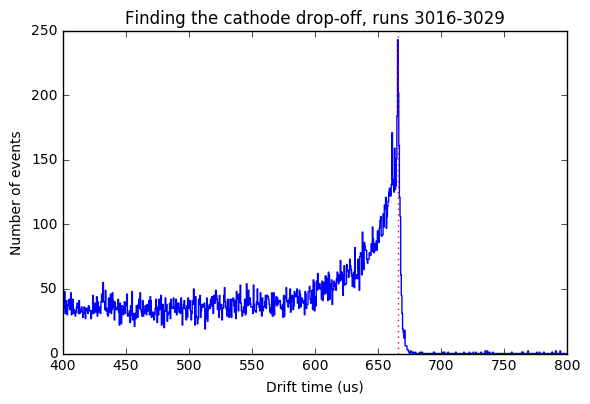

drift_time in [655750.0, 675750.0) selection: 190912 events removed (1.85% passed)


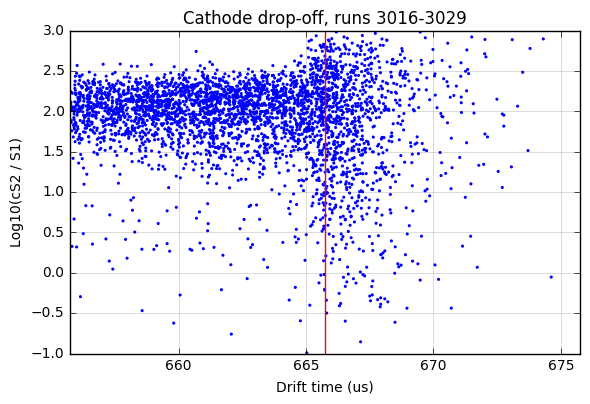

drift_time below 7000.0 selection: 148572 events removed (23.62% passed)
logcsratio in [1, 3.5) selection: 9112 events removed (80.17% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,336416,194513,141903,0.578192,0.578192
1,drift_time below 7000.0,194513,45941,148572,0.236185,0.136560
2,"logcsratio in [1, 3.5)",45941,36829,9112,0.801659,0.109475


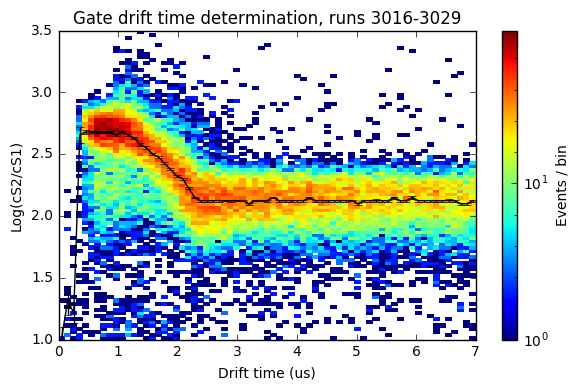

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1940_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2040_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2140_Basics.root


Drift velocity determined at 1.456 km/sec
Now loading 2397-2409


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2240_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2341_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0041_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0141_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0342_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0442_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1639_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1739_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1839_Basics.root
DEBUG:hax.minitrees] Removing weird index column


Finite cs1 selection: 27813 events removed (87.27% passed)
Cathode dt fitted at 654.2


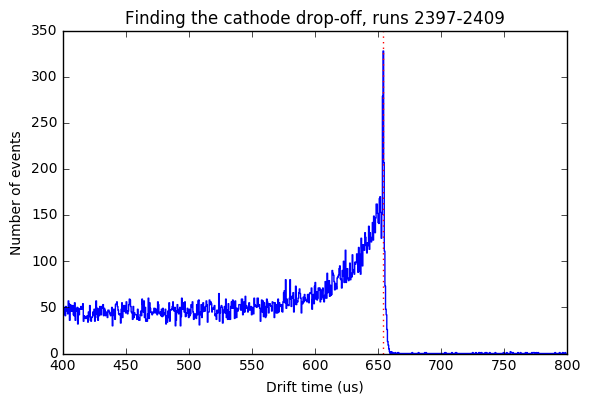

drift_time in [644250.0, 664250.0) selection: 186791 events removed (2.01% passed)


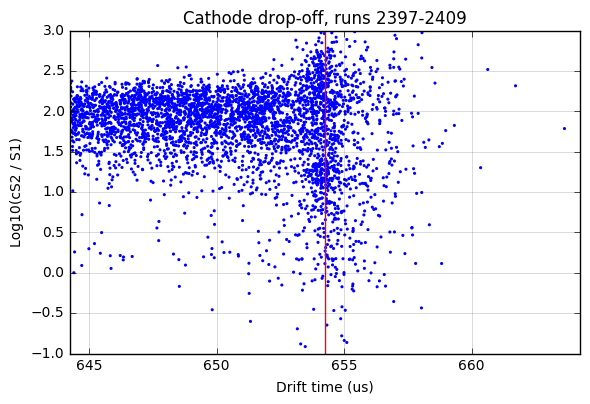

drift_time below 7000.0 selection: 153795 events removed (19.32% passed)
logcsratio in [1, 3.5) selection: 3608 events removed (90.20% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,218427,190614,27813,0.872667,0.872667
1,drift_time below 7000.0,190614,36819,153795,0.193160,0.168564
2,"logcsratio in [1, 3.5)",36819,33211,3608,0.902007,0.152046


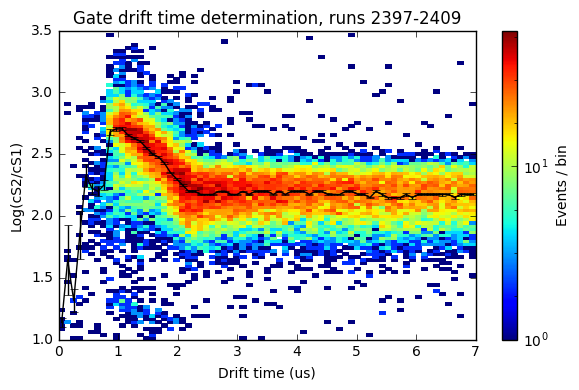

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0254_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0354_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0454_Basics.root


Drift velocity determined at 1.482 km/sec
Now loading 3068-3086


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0555_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0655_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0755_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0855_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1057_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1157_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1702_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1803_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_2003_Basics.root
DEBUG:hax.minitrees] Removing weird index column


Finite cs1 selection: 35053 events removed (84.76% passed)
Cathode dt fitted at 673.2


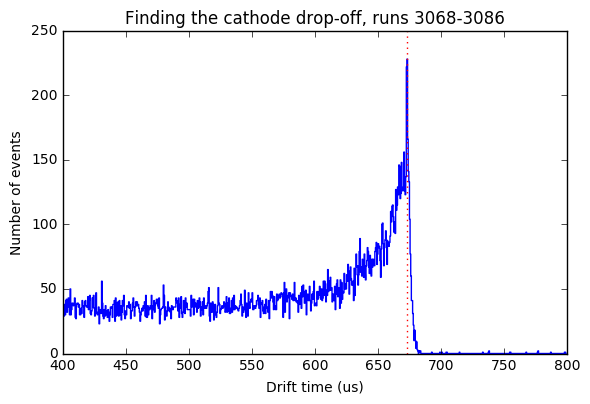

drift_time in [663250.0, 683250.0) selection: 191230 events removed (1.89% passed)


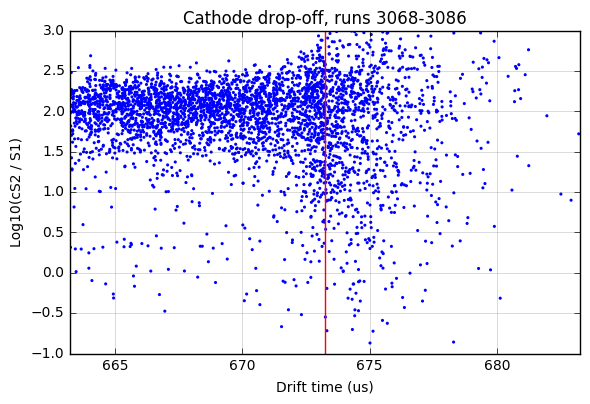

drift_time below 7000.0 selection: 149327 events removed (23.39% passed)
logcsratio in [1, 3.5) selection: 4651 events removed (89.80% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,229963,194910,35053,0.847571,0.847571
1,drift_time below 7000.0,194910,45583,149327,0.233867,0.198219
2,"logcsratio in [1, 3.5)",45583,40932,4651,0.897966,0.177994


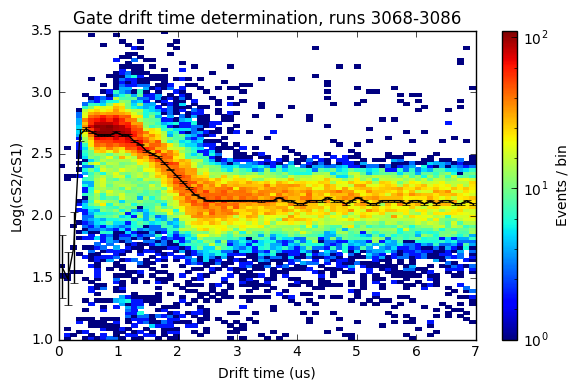

Drift velocity determined at 1.440 km/sec


In [6]:
dt_us_range_for_vd = (400, 800)
dt_binsize = 0.5

# Offset for drift time due to small amount of liquid above anode and the drift in the gas (until center of S2 is reached)
# This offset may depend on (x,y) if the gate mesh is warped, but we have no information on this.
dt_offset = 1.7 * units.us  # From looking at figures below
# dl = pax_config['WaveformSimulator']['gate_to_anode_distance'] - pax_config['WaveformSimulator']['elr_gas_gap_length']
# dt_offset = dl / pax_config['WaveformSimulator']['drift_velocity_liquid_above_gate']

for ds in datasets:
    print("Now loading %s" % ds['desc'])
    data = hax.minitrees.load(ds['runs'], 'Basics')
    data['logcsratio'] = np.log10(data['cs2']/data['cs1'])
    data = cuts.isfinite(data, 'cs1')
    
    ##
    # Drift velocity determination
    ##
    q = Hist1d(data['drift_time'] / units.us, bins=np.arange(*dt_us_range_for_vd, step=dt_binsize))
    cathode_dt = q.bin_centers[np.argmax(q.histogram)] * units.us
    ds['cathode_dt'] = cathode_dt
    print("Cathode dt fitted at %0.1f" % (cathode_dt / units.us))
    
    # Diagnostic plot 1 (dt hist1d)
    q.plot()
    plt.xlabel("Drift time (us)")
    plt.ylabel("Number of events")
    plt.tight_layout()
    plt.axvline(cathode_dt / units.us, color='red', linestyle=':')
    plt.savefig('cathode_dt_%s' % ds['desc'])
    plt.title("Finding the cathode drop-off, runs %s" % ds['desc'])
    plt.show()
    
    # Diagnostic plot 2 (scatter logsratio(dt))
    range_to_ex = (cathode_dt - 10 * units.us, cathode_dt + 10 * units.us)
    d = cuts.range_selection(data, 'drift_time', range_to_ex)
    plt.scatter(d['drift_time'] / units.us, 
                np.log10(d['cs2']/d['s1']),
                marker='.', s=20, edgecolors='none')
    plt.axvline(cathode_dt / units.us, color='red')
    plt.ylim(-1, 3)
    plt.xlim(*(np.array(range_to_ex) / units.us))
    plt.ylabel("Log10(cS2 / S1)")
    plt.xlabel("Drift time (us)")
    plt.grid(alpha=0.2, linestyle='-')
    plt.tight_layout()
    plt.title("Cathode drop-off, runs %s" % ds['desc'])
    plt.savefig('cathode_scatter_%s' % ds['desc'])
    plt.show()
    
    # Plot 3: gate dt. Again, nothing computed here.
    d_neargate = cuts.below(data, 'drift_time', 7 * units.us)
    d_neargate = cuts.range_selection(d_neargate, 'logcsratio', (1, 3.5))
    display(cuts.history(d_neargate))
    mh = Histdd(d_neargate['drift_time'] / units.us, 
                d_neargate['logcsratio'],
                bins=(np.linspace(0, 7, 70), np.linspace(1, 3.5, 100)),
                axis_names=['dt', 'logcsratio'])
    mh.plot(log_scale=True, cblabel='Events / bin')
    plt.xlabel("Drift time (us)")
    plt.ylabel("Log(cS2/cS1)")

    median = mh.percentile(50, axis='logcsratio')
    n_per_slice = mh.sum(axis='logcsratio')
    sigma = (mh.percentile(stats.norm.cdf(1)*100, axis='logcsratio') - 
             mh.percentile(stats.norm.cdf(-1)*100, axis='logcsratio'))/2
    plt.errorbar(median.bin_centers, median.histogram,
                 yerr=sigma/np.sqrt(n_per_slice.histogram), c='k')
    
#     dont_fit_before = 1
#     mask = median.bin_centers > dont_fit_before

#     def bla(t, t_switch, a, b):
#         return b - a * np.clip(t, 0, t_switch)
#     popt, pcov = optimize.curve_fit(bla, 
#                                     median.bin_centers[mask], 
#                                     median.histogram[mask], 
#                                     sigma = sigma[mask]/np.sqrt(n_per_slice[mask]),
#                                     p0=[2, 1, 3])
#     ds['gate_dt'] = gate_dt = popt[0] * units.us
#     ds['logcsratio_mean'] = popt[2]
#     print("Gate drift time fitted at %0.2f us" % (gate_dt/units.us))
    
#     plt.axvline(gate_dt / units.us, linestyle=':', c='k')
#     t = np.linspace(1, 7, 100)
#     plt.plot(t, bla(t, *popt), c='white', linestyle=':')
    plt.title("Gate drift time determination, runs %s" % ds['desc'])
    plt.tight_layout()
    plt.savefig('gate_dt_%s' % ds['desc'])
    plt.show()
    
    ##
    # 
    ##
        
    ds['drift_velocity'] = pax_config['DEFAULT']['tpc_length'] / (cathode_dt - dt_offset)
    print("Drift velocity determined at %0.3f km/sec" % (ds['drift_velocity'] / (units.km/units.s)))

In [7]:
import emcee

import corner

D_fit_range_us = (50, 350)
# D_fit_range_us = (100, 400)

sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)

s2_bounds = (1e4, 2e4)
aft_bounds = (0.55, 0.7)

D_guess = 30 * units.cm**2 / units.s
w0_guess = 300 * units.ns
wsigma_guess = 30 * units.ns

def diffusion_model(t, D, vd, w0):
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)

def fit_diffusion(data, vd, outlier_cap=-15):
    d = data

    def loglikelihood(params):
        D, w0, wsigma = params

        # Range constraint / uniform prior. Probably not necessary anymore.
        if not (5 < D < 50 and (100  < w0/units.ns < 500) and (10 < wsigma/units.ns < 100)):
            return -float('inf')

        D *= (units.cm**2 / units.s)

        y = d['s2_range_50p_area']
        model = diffusion_model(d['drift_time'], D, vd, w0)

        # Gaussian loglikelihood, with outlier contribution capped
        inv_sigma2 = 1.0/wsigma**2
        result = -0.5 * ((y-model)**2*inv_sigma2 - np.log(inv_sigma2))
        result = np.clip(result, outlier_cap, 1)
        return np.sum(result)

    guess = np.array([D_guess/(units.cm**2 / units.s), w0_guess, wsigma_guess])
    n_walkers = 50
    n_steps = 250
    n_dim = len(guess)

    # Hack to show a progress bar during the computation
    def lnprob(x):
        lnprob.t.update(1)
        return loglikelihood(x)
    lnprob.t = tqdm(desc='Computing likelihoods', total=n_walkers * n_steps)

    # Run the MCMC sampler
    p0 = np.array([np.random.uniform(0.9, 1.1, size=n_dim) for i in range(n_walkers)]) * guess
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob)
    samples = sampler.run_mcmc(p0, n_steps)

    # Remove first 50 samples for each walker (burn-in)
    samples = sampler.chain.ravel()
    samples = sampler.chain[:, 50:, :].reshape((-1, n_dim))
    return samples

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0546_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0646_Basics.root


Now loading 3016-3029


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0747_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0847_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_0947_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1047_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1148_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1248_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1348_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1448_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1548_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160922_1719_Basics.root
DEBUG:hax.minitrees] Removing weird index column


Finite cs1 selection: 141903 events removed (57.82% passed)


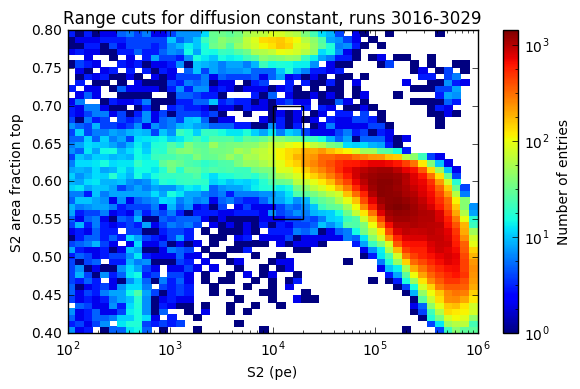

s2 in [10000.0, 20000.0) selection: 189532 events removed (2.56% passed)
s2_area_fraction_top in [0.55, 0.7) selection: 2085 events removed (58.14% passed)
drift_time in [50000.0, 350000.0) selection: 2465 events removed (14.88% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,336416,194513,141903,0.578192,0.578192
1,"s2 in [10000.0, 20000.0)",194513,4981,189532,0.025608,0.014806
2,"s2_area_fraction_top in [0.55, 0.7)",4981,2896,2085,0.581409,0.008608
3,"drift_time in [50000.0, 350000.0)",2896,431,2465,0.148826,0.001281


Computing likelihoods: 12550it [00:56, 223.07it/s]


(array([  21.84,  303.91,   55.62]), array([  0.34,  15.91,   2.34]))


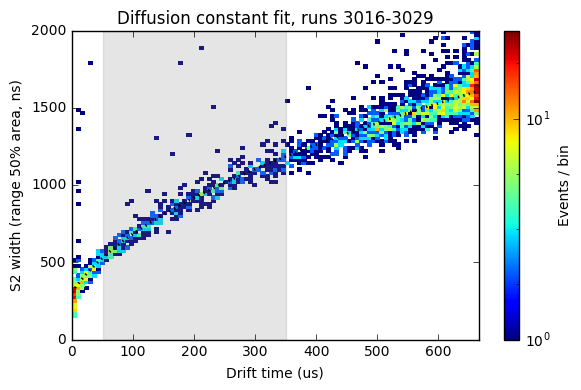

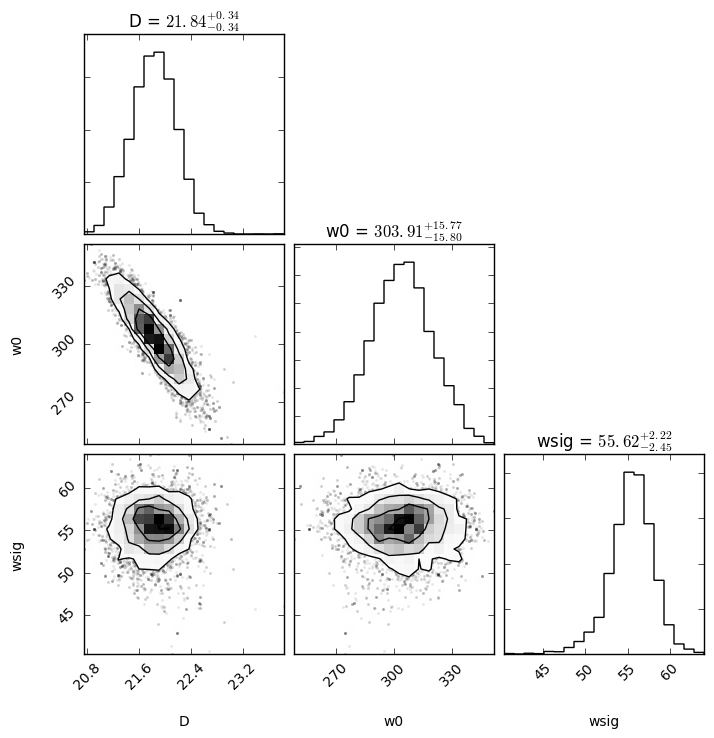

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1940_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2040_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2140_Basics.root


Now loading 2397-2409


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2240_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_2341_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0041_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0141_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0342_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160826_0442_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1639_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1739_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160825_1839_Basics.root
DEBUG:hax.minitrees] Removing weird index column


Finite cs1 selection: 27813 events removed (87.27% passed)


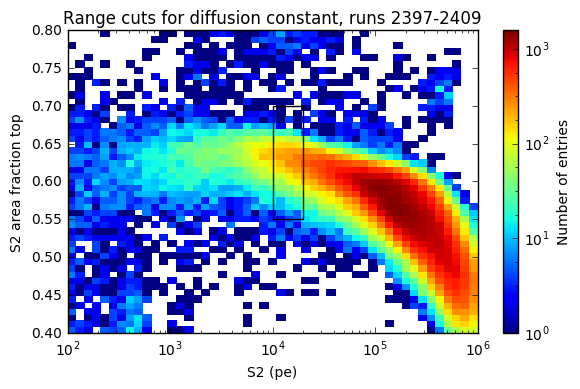

s2 in [10000.0, 20000.0) selection: 184948 events removed (2.97% passed)
s2_area_fraction_top in [0.55, 0.7) selection: 159 events removed (97.19% passed)
drift_time in [50000.0, 350000.0) selection: 4817 events removed (12.53% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,218427,190614,27813,0.872667,0.872667
1,"s2 in [10000.0, 20000.0)",190614,5666,184948,0.029725,0.025940
2,"s2_area_fraction_top in [0.55, 0.7)",5666,5507,159,0.971938,0.025212
3,"drift_time in [50000.0, 350000.0)",5507,690,4817,0.125295,0.003159


Computing likelihoods: 12550it [00:57, 218.69it/s]


(array([  19.27,  353.8 ,   43.82]), array([ 0.2 ,  9.11,  1.35]))


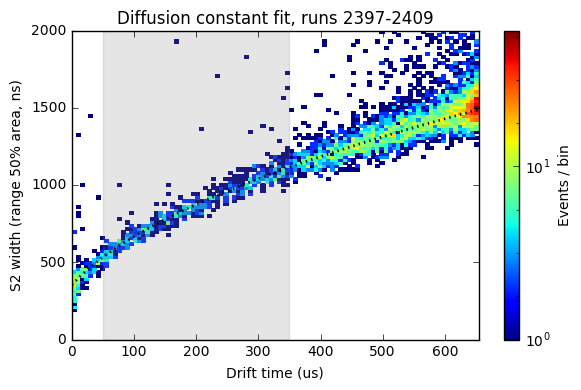

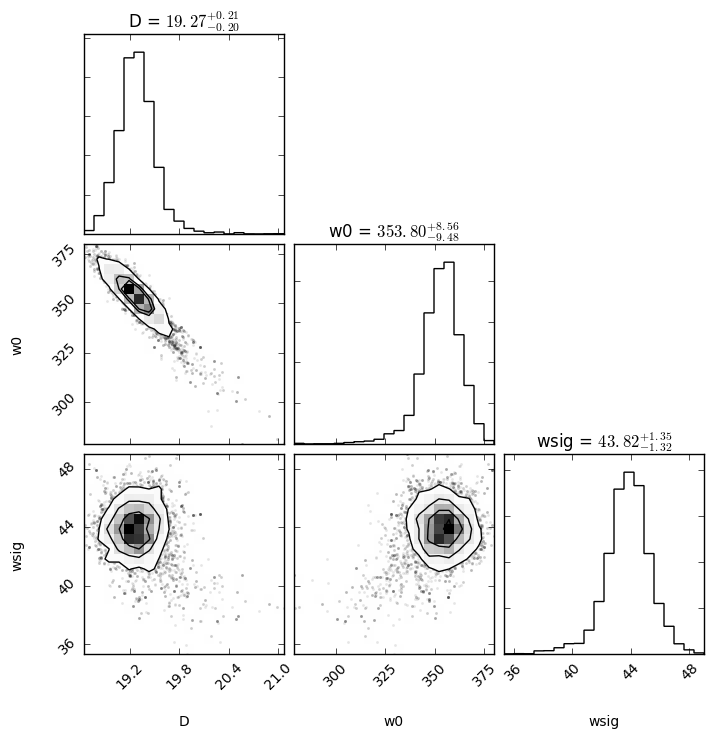

DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0254_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0354_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0454_Basics.root


Now loading 3068-3086


DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0555_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0655_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0755_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_0855_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1057_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1157_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1702_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_1803_Basics.root
DEBUG:hax.minitrees] Found minitree at /home/aalbers/minitrees/160924_2003_Basics.root
DEBUG:hax.minitrees] Removing weird index column


Finite cs1 selection: 35053 events removed (84.76% passed)


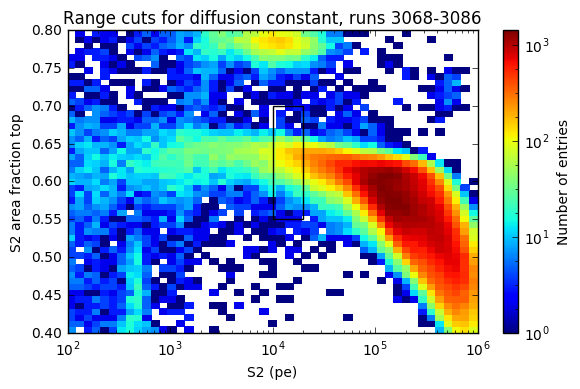

s2 in [10000.0, 20000.0) selection: 190012 events removed (2.51% passed)
s2_area_fraction_top in [0.55, 0.7) selection: 1966 events removed (59.86% passed)
drift_time in [50000.0, 350000.0) selection: 2502 events removed (14.67% passed)


,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite cs1,229963,194910,35053,0.847571,0.847571
1,"s2 in [10000.0, 20000.0)",194910,4898,190012,0.025130,0.021299
2,"s2_area_fraction_top in [0.55, 0.7)",4898,2932,1966,0.598612,0.012750
3,"drift_time in [50000.0, 350000.0)",2932,430,2502,0.146658,0.001870


Computing likelihoods: 12550it [00:56, 225.03it/s]


(array([  22.83,  303.87,   54.59]), array([  0.3 ,  15.33,   2.16]))


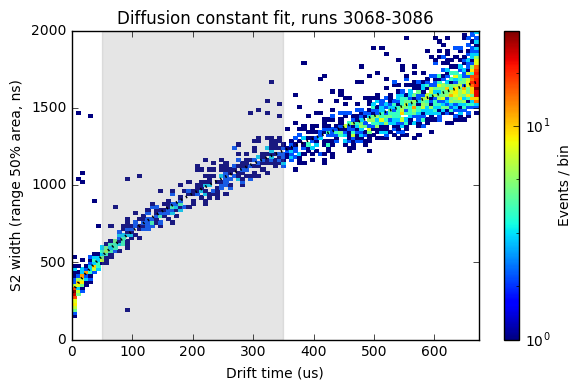

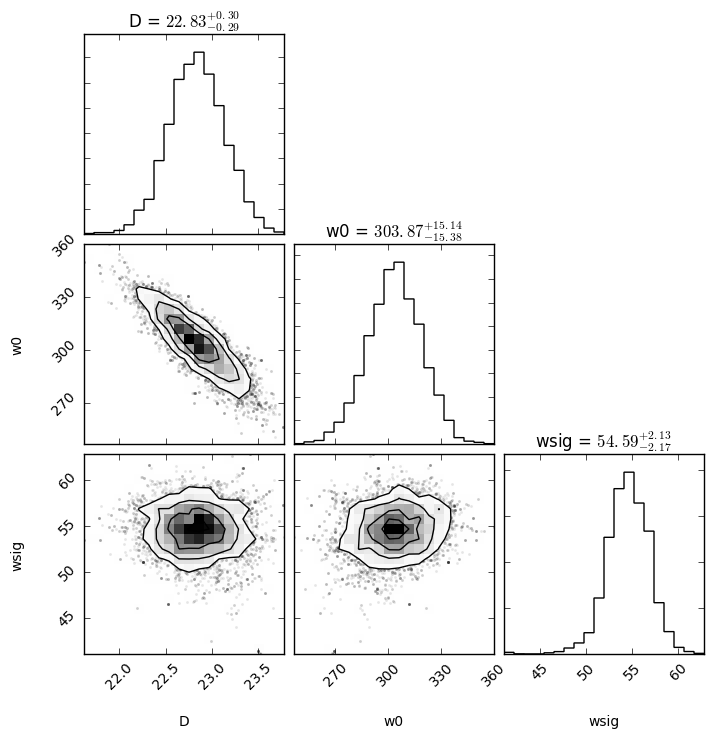

In [8]:
for ds in datasets:
    print("Now loading %s" % ds['desc'])
    data = hax.minitrees.load(ds['runs'], 'Basics')
    data = cuts.isfinite(data, 'cs1')
    
    ## 
    # Energy and aft cuts
    ##
    mh = Histdd(data['s2'], data['s2_area_fraction_top'], 
                bins=(np.logspace(2, 6, 50), np.linspace(0.4, 0.8, 50))).plot(log_scale=True)
    draw_box(s2_bounds, aft_bounds)
    plt.xscale('log')
    plt.xlabel('S2 (pe)')
    plt.ylabel('S2 area fraction top')
    plt.title("Range cuts for diffusion constant, runs %s" % ds['desc'])
    plt.tight_layout()
    plt.savefig('D_range_cuts_%s' % ds['desc'])
    plt.show()
    
    data = cuts.range_selections(data, ('s2', s2_bounds), ('s2_area_fraction_top', aft_bounds))
    
    ##
    # dt cut
    ##
    n_bins = 100
    tmax_us = ds['cathode_dt'] / units.us
    
    mh = Histdd(data['drift_time']/units.us, data['s2_range_50p_area'], 
                axis_names=['dt', 'width'],
                bins=(np.linspace(0, tmax_us, n_bins), np.linspace(0, 2e3, n_bins)));
    mh.plot(log_scale=True, cblabel='Events / bin')
    plt.xlabel('Drift time (us)')
    plt.ylabel('S2 width (range 50% area, ns)')
    plt.axvspan(*D_fit_range_us, alpha=0.2, color='gray')

    
    data = cuts.range_selection(data, 'drift_time', np.array(D_fit_range_us) * units.us)
    display(cuts.history(data))
    
    ##
    # Finally, the fit
    ##
    samples = fit_diffusion(data, vd=ds['drift_velocity'])
           
    # Get and return the fit result
    fit_result = np.median(samples, axis=0)
    l, r = np.percentile(samples, 100 * stats.norm.cdf([-1, 1]), axis=0)
    sigma = (r - l)/2
    q = np.round(fit_result, 2), np.round(sigma, 2)
    print(q)
    ds['D'] = fit_result[0] *  units.cm**2 / units.s
    ds['w0'] = fit_result[1]
    
    _ts = np.linspace(0, 700, 100) * units.us
    plt.plot(_ts / units.us, 
             diffusion_model(_ts, ds['D'], ds['drift_velocity'], ds['w0']),
             linestyle=':', linewidth=2, c='k')
    plt.title("Diffusion constant fit, runs %s" % ds['desc'])
    plt.tight_layout()
    plt.savefig('D_dt_cut_%s' % ds['desc'])
    plt.show()
    
    # Show a corner plot
    corner.corner(samples, show_titles=True, labels=['D', 'w0', 'wsig'])
    plt.savefig('D_corner_%s' % ds['desc'])
    plt.show()


# Combination plots

In [82]:
import pandas as pd 
data = pd.DataFrame(datasets)
data['experiment'] = 'XENON1T'
data['color'] = 'b'

other_data = pd.DataFrame([
    dict(drift_field=181 *units.V/units.cm,  # From https://arxiv.org/abs/1310.8214
         experiment='LUX',
         color='purple',
         drift_velocity=40 * units.cm / (270 * units.us),  # From numbers in https://arxiv.org/abs/1405.5906
        ),
    dict(drift_field=530 * units.V/units.cm,
         experiment='XENON100',
         color='r',
         drift_velocity=1.74 * units.km/units.s,
         D=16 * units.cm**2 / units.s),
    dict(drift_field=730 * units.V/units.cm,
         experiment='XENON10',
         color='orange',
         drift_velocity=1.88 * units.km/units.s,
         D=12 * units.cm**2 / units.s),
])

data = pd.concat((data, other_data,))

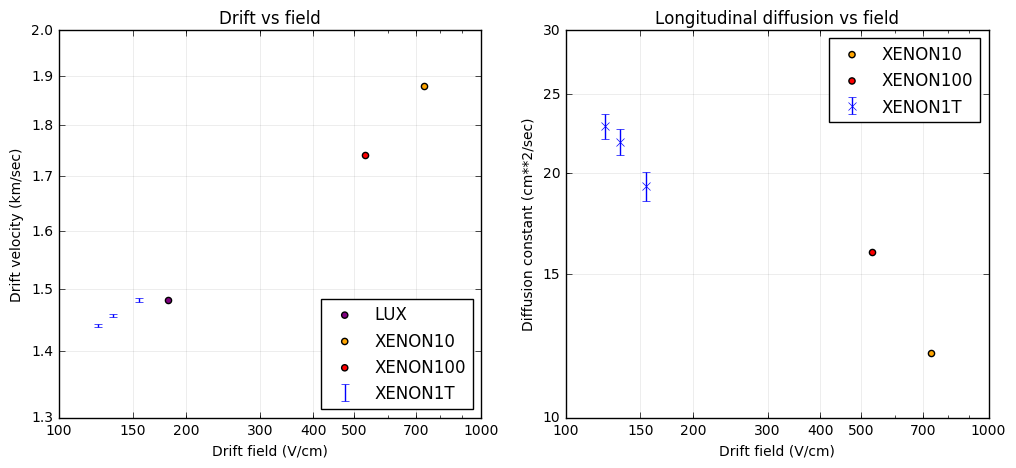

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12), sharex=True)
# plt.subplots_adjust(hspace=0.001)

for experiment, d in data.groupby('experiment'):
    plt.sca(ax1)
    c = d.color.iloc[0]
    if experiment == 'XENON1T':
        plt.errorbar(d.drift_field, d.drift_velocity / (units.km/units.s), 
                     yerr=d.drift_velocity / (units.km/units.s) * 0.002,
                     c=c, linestyle='',
                     label=experiment)
        
    else:
        plt.scatter(d.drift_field, d.drift_velocity / (units.km/units.s), 
                    c=c,
                    label=experiment)
    
    plt.sca(ax2)
    if experiment == 'XENON1T':
        plt.errorbar(d.drift_field, d.D / (units.cm**2/units.s), 
                     yerr=0.8, 
                     c=c, linestyle='', marker='x', 
                     label=experiment)
    else:
        if np.isnan(d.iloc[0].D):
            continue
        plt.scatter(d.drift_field, d.D / (units.cm**2/units.s), 
                    c=c, label=experiment)

## Theory
# plt.sca(ax1)
# abdrift =pd.read_csv('AB_driftvelocity.csv', skiprows=1, names=['E', 'v', 'bla'])
# plt.plot(abdrift.E, abdrift.v * units.cm/units.s / (units.km/units.s), 
#          c='k', label='Theory') 
    
## Ticks, legend, etc.
    
plt.sca(ax1)
plt.ylim(1.3, 2)
plt.legend(loc='lower right', scatterpoints=1, numpoints=1)
plt.title("Drift vs field")
plt.yscale('log')
plt.ylabel("Drift velocity (km/sec)")
ax1.set_yticks([1.3, 1.4, 1.5,1.6, 1.7, 1.8, 1.9, 2])

plt.sca(ax2)
plt.ylim(10, 30)
plt.ylabel("Diffusion constant (cm**2/sec)")
plt.legend(loc='upper right', scatterpoints=1, numpoints=1)
plt.title("Longitudinal diffusion vs field")
plt.yscale('log')
ax2.set_yticks([10, 15, 20, 25, 30])

from matplotlib.ticker import ScalarFormatter
for ax in (ax1, ax2):
    plt.sca(ax)
    plt.xscale('log')
    plt.xlabel("Drift field (V/cm)")
    plt.grid(alpha=0.1, linestyle='-')
    ax.set_xticks([100, 150, 200, 300, 400, 500, 700, 1000])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.set_xlim(100, 1000)
    
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

plt.savefig('drift_field_effects')

# Old stuff when I put the gate somewhere else

In [ ]:
def gate_dt_model(drift_velocity, t0, d_gate):
    return t0 + d_gate / drift_velocity


vs = np.linspace(1.3, 1.7, 100) * units.km/units.s
plt.plot(vs, 
         gate_dt_model(vs, 0 * units.us, 0.35 * units.cm))
plt.scatter(data['drift_velocity'], 
            data['gate_dt'])


In [ ]:
popt, pcov = optimize.curve_fit(gate_dt_model, d1t.drift_velocity, d1t.gate_dt, bounds=[(0, 0), 
                                                                                        (2 * units.us, 5 * units.cm)])
print("Base time: %0.2f us" % (popt[0] / units.us))
print("Extra len: %0.2f cm" % (popt[1] / units.cm))

# Quick MC to check

In [ ]:
vd = ds['drift_velocity']
D = 38 * units.cm**2 / units.s  # ds['D']

def to_r50p(ts):
    return np.percentile(ts, 75) - np.percentile(ts, 25)

mean_drift_times = np.linspace(100, 700, 1000) * units.us
r50s = np.zeros_like(mean_drift_times)
for i, t in tqdm(enumerate(big_ts)):
    ts = np.random.normal(0, 
                          max(1e-6, np.sqrt(2 * D * t)/ vd),
                          size=10000)
    r50s[i] = to_r50p(ts)

In [ ]:
mh.plot(log_scale=True, cblabel='Events / bin', cmap=plt.cm.viridis)
plt.xlabel('Drift time (us)')
plt.ylabel('S2 width (range 50% area, ns)')

plt.scatter(big_ts / units.us, r50s, marker='.', edgecolors='none', c='r', s=3)


_ts = np.linspace(0, 700, 100) * units.us
plt.plot(_ts / units.us, 
         diffusion_model(_ts, ds['D'], ds['drift_velocity'], ds['w0']),
         linestyle=':', linewidth=2, c='k')